<a href="https://colab.research.google.com/github/WesleyAldridge/HW3_MachineLearning/blob/master/HW3_MachineLearning_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2

## Do fine-tuning with data augmentation.

In [0]:
from google.colab import files

from keras import layers, models, optimizers
from keras.applications import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import os

import matplotlib.pyplot as plt

import numpy as np

import zipfile

### Retrieving cats_and_dogs data, creating directories

In [44]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2019-04-18 01:29:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  41.2MB/s    in 1.6s    

2019-04-18 01:29:06 (41.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Loading VGG19

In [0]:
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Creating model with VGG19 convolutional base

In [46]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


### Data augmentation

In [47]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### Running model

In [49]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc']
)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 38s 376ms/step - loss: 0.5412 - acc: 0.7105 - val_loss: 0.3951 - val_acc: 0.8080
Epoch 2/30
100/100 [==============================] - 33s 329ms/step - loss: 0.3936 - acc: 0.8140 - val_loss: 0.3089 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 32s 318ms/step - loss: 0.3268 - acc: 0.8590 - val_loss: 0.2693 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 33s 326ms/step - loss: 0.2913 - acc: 0.8715 - val_loss: 0.2383 - val_acc: 0.8980
Epoch 5/30
100/100 [==============================] - 33s 327ms/step - loss: 0.2605 - acc: 0.8860 - val_loss: 0.2447 - val_acc: 0.8980
Epoch 6/30
100/100 [==============================] - 32s 321ms/step - loss: 0.2438 - acc: 0.8995 - val_loss: 0.2039 - val_acc: 0.9100
Epoch 7/30
100/100 [==============================] - 34s 335ms/step - loss: 0.2310 - acc: 0.9085 - val_loss: 0.1864 - val_acc: 0.9190
Epoch 8/30
100/100 [==============================] - 3

### Graphing accuracy

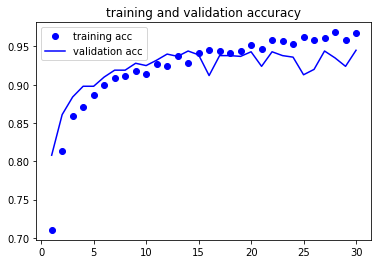

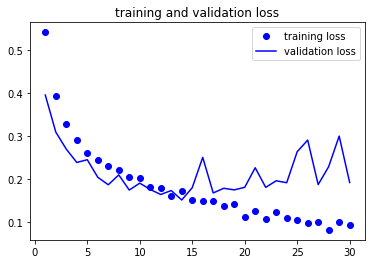

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Print out validation loss and accuracy

In [51]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.18755165252659936
Validation accuracy: 0.9449999928474426


### Save the model

In [53]:
model_fname = 'cats_and_dogs_finetuning.h5' 
model.save(model_fname)

with open(model_fname, 'r+') as f:
  files.download(model_fname)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51270, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil